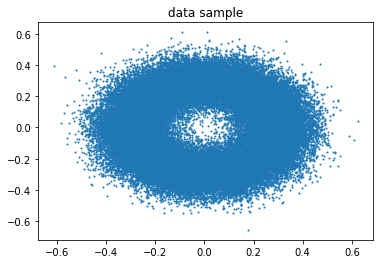

In [10]:
import numpy as np
import torch.nn as nn
import torch.nn.init
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, num_clusters, n_data):

        self.num_clusters = num_clusters
        self.n_data = n_data
        _data = np.random.randn(self.n_data, 2)
        _label = np.ndarray(self.n_data, dtype=np.int)
        _mu = []
        _sig = 0.08
        for k in range(num_clusters):
            _mu.append([0.3 * np.cos(2.0 * np.pi * k / num_clusters), 0.3 * np.sin(2.0 * np.pi * k / num_clusters)])
        for i in range(n_data):
            _data[i][0] = _sig * _data[i][0] + _mu[i % num_clusters][0]
            _data[i][1] = _sig * _data[i][1] + _mu[i % num_clusters][1]
            _label[i] = i % num_clusters

        self.data = torch.as_tensor(_data, dtype=torch.float32)
        self.label = torch.as_tensor(_label, dtype=torch.int64)

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]



class UniformDiscreteDistribution(object):

    def __init__(self, n_category):
        self.n_category = n_category

    def sampling(self, _batch_size):
        sample = torch.randint(self.n_category, size=(_batch_size,))
        return torch.nn.functional.one_hot(sample, num_classes=self.n_category).float()


class Generator(nn.Module):

    def __init__(self, num_z, num_c):
        super(Generator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=num_z + num_c, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.LeakyReLU(negative_slope=0.1),
            torch.nn.Linear(in_features=16, out_features=2, bias=True),
        )

    def forward(self, z, c):
        zc = torch.cat([z, c], dim=1)
        return self.layer(zc)



class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=1, bias=True),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.layer(x)


class DiscreteEncoder(nn.Module):

    def __init__(self, n_category):
        super(DiscreteEncoder, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=16, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=n_category, bias=True),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layer(x)


z_size = 16
n_categories = 10
n_data = 60000
dataset = CustomDataSet(num_clusters=10, n_data=n_data)
data = dataset.data.numpy()
plt.title('data sample')
plt.scatter(data[:, 0], data[:, 1], s=1)
plt.show()

In [0]:
encoder = DiscreteEncoder(n_category=n_categories)
discriminator = Discriminator()
generator = Generator(num_z=z_size, num_c=n_categories)

e_optimizer = torch.optim.SGD(encoder.parameters(), lr=0.001)
d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=0.001)
g_optimizer = torch.optim.SGD(generator.parameters(), lr=0.001)

c_distribution = UniformDiscreteDistribution(n_category=n_categories)

num_epochs = 300
batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

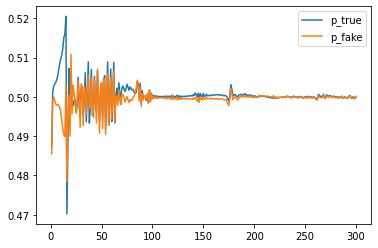

In [26]:
p_real_list = []
p_fake_list = []
for epoch in range(1, num_epochs+1):
    avg_p_real = 0.0
    avg_p_fake = 0.0
    for batch_index, mini_batch_data in enumerate(loader):
        
        d_optimizer.zero_grad()
        p_real = discriminator(mini_batch_data).mean()
        c = c_distribution.sampling(batch_size)
        z = torch.randn(batch_size, z_size)
        x = generator(z, c)
        p_fake = discriminator(x).mean()
        (-torch.log(p_real) - torch.log(1.0 - p_fake)).backward()
        d_optimizer.step()

        e_optimizer.zero_grad()
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, z_size)
        c = c_distribution.sampling(batch_size)
        x = generator(z, c)
        g_loss_from_d = (-torch.log(discriminator(x))).mean()
        g_loss_from_e = (-c * torch.log(encoder(x))).mean()
        generator_loss = g_loss_from_d + g_loss_from_e
        generator_loss.backward()
        e_optimizer.step()
        g_optimizer.step()
  
        avg_p_fake += p_fake.item()
        avg_p_real += p_real.item()
    p_real_list.append(avg_p_real/len(loader))
    p_fake_list.append(avg_p_fake/len(loader))

plt.plot(np.arange(1, len(p_real_list) + 1), p_real_list, label='p_true')
plt.plot(np.arange(1, len(p_fake_list) + 1), p_fake_list, label='p_fake')
plt.legend()
plt.show()


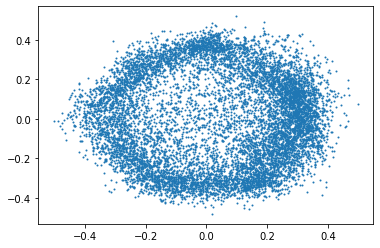

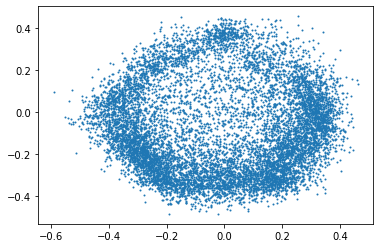

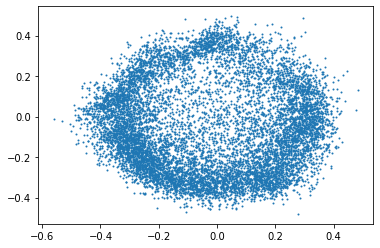

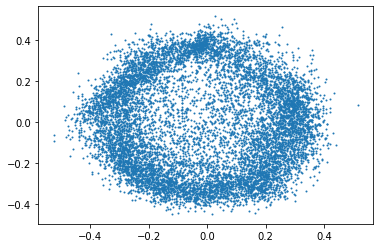

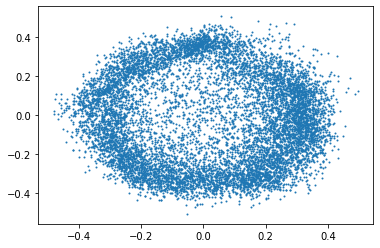

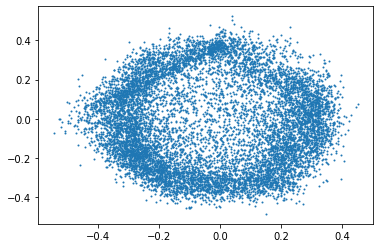

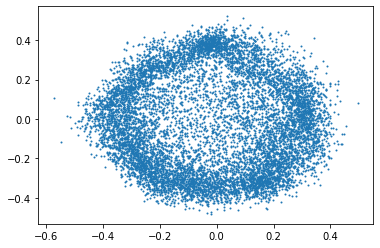

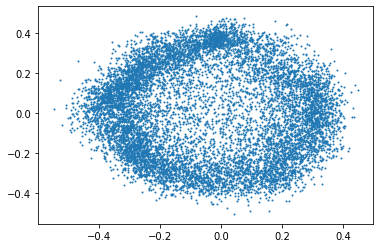

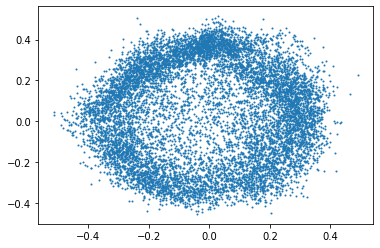

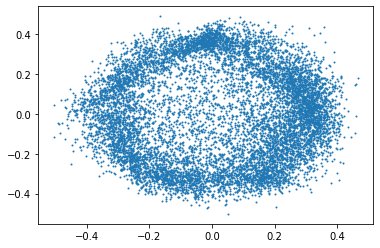

In [29]:
for k in range(n_categories):
    sample = torch.zeros(10000, dtype=torch.int64)
    sample.fill_(k)
    c = torch.nn.functional.one_hot(sample, num_classes=n_categories).float()
    x = generator(torch.randn(10000, z_size), c).data.numpy()
    plt.scatter(x[:, 0], x[:, 1], s=1)
    plt.show()